# Imports

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats.mstats import pearsonr, spearmanr
import pywt
%matplotlib inline

import scipy
# from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
from sklearn.isotonic import IsotonicRegression


idx = pd.IndexSlice
sns.set_style('whitegrid')
sns.set_palette('tab10')

# if you run this notebook on your personal computer you'll have to download the data
base_file_path = '~/kaggle-data/jpx-stock-exchange-prediction/'

# Project is a work in progress

## What's been accomplished
* Monotonic and bounded CDFs
* Custom user defined functions
* Interesting looking PMFs

## To-do list
* Construct isotonic regression from scratch (for educational purposes)
* try out `kstest` for simulated gammas
* generate interpolated cdfs and compute pdfs (pmfs in near continuous limit)
* construct ficitious kolmogorov smirnov tests
* think about fitting a general exponential family of distributions (is this even possible?)
* Last but definitely not least: documentation and annotations

## User defined functions (UDF)
Useful for pandas groupby operations

In [53]:
def savgol_pandas(series:pd.Series, window_length, polyorder)->pd.Series:
    '''
    Savitzky-Golay filter for a pandas groupby operation.  
    For polyorder=1 this filter roughly acts like a moving average.

    Args:
    Series: Noise data to smooth
    window_length: Size of the sliding window 
    polyorder:  interpolation polynomial order, usually 1 is just fine.  Higher orders can cause boundary issues.
    '''
    data = scipy.signal.savgol_filter(series.values, window_length, polyorder)
    return pd.Series(data = data, index = series.index)

def gradient_pandas(series:pd.Series, index_level = -1)->pd.Series:
    '''
    Custom numpy gradient tool for groupby operations on multi-index pandas dataframes.  
    X data is taken to be in the index of the series, Y data is in series.values.
    Gradient is used to return a centered derivative (i.e. the return is the same length as the input.)
    
    Args:
    series: series.values should have the y data, series.index should have the X data in one of the index levels.
    index_level: the tier of the index that continas the X data
    '''

    price = series.values
    index = series.index.get_level_values(index_level)
    data = np.gradient(price)/np.gradient(index)
    return pd.Series(data=data, index = series.index)

def GaussKernelSmoother_pandas(series:pd.Series, sigma=3, order = 0)->pd.Series:
    '''
    1D gaussian kernel smoother meant for smoothing probability distribution functions.
    Compatible with pandas groupby.

    Args:
    series: The data to smooth.
    sigma: Similar to the averaging window.
    order: Typically kept at 0 for gaussian kernel smoothing.  
    '''

    smoothed = gaussian_filter1d(series.dropna(), sigma, order)
    smoothed_series = pd.Series(index = series.index)
    smoothed_series[series.isna()] = np.nan
    smoothed_series[~series.isna()] = smoothed
    return smoothed_series

def bullSpread_pdgroupby(obj = pd.core.groupby.generic.SeriesGroupBy) -> pd.Series:
    '''
    Computes numerical first derivative, specifically  meant for data in a multi-index pandas dataframe.
    Derivative is of the form y_{i+1} - y_{i-1}, from the finite difference approach.

    Args: 
    obj: Pass in the groupby object of the pandas dataframe.
    '''
    return obj.shift(-1)-obj.shift(1)



    return obj.shift(1)-obj.shift(-1)
def butterflySpread_pdgroupby(obj = pd.core.groupby.generic.SeriesGroupBy) -> pd.Series:
    '''
    Computes numerical second derivative, specifically  meant for data in a multi-index pandas dataframe.
    Derivative is of the form y_{i+1} - 2*y{i} + y_{i-1}, from the finite difference approach.

    Args: 
    obj: Pass in the groupby object of the pandas dataframe.
    '''
    return obj.shift(1)+obj.shift(-1) -2*obj.shift(0)

# Exploratory data analysis

## Data cleaning

In [54]:
options_import = pd.read_csv(base_file_path+'train_files/options.csv')
# options_import.to_json()
# import pickle
# with open('options_data', 'wb') as f:
#     pickle.dump(options_import.to_json(), f)

/tmp/ipykernel_400717/3569553231.py:1: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  options_import = pd.read_csv(base_file_path+'train_files/options.csv')


In [55]:
options_import['Date'] = pd.to_datetime(options_import['Date'])

options_import['Expiry'] =options_import.LastTradingDay.astype(str)
options_import['Expiry'] = pd.to_datetime(options_import['Expiry'], format = '%Y%m%d')

drop_cols = ['NightSessionOpen', 'NightSessionHigh',
       'NightSessionLow', 'NightSessionClose', 'DaySessionOpen',
       'DaySessionHigh', 'DaySessionLow', 'DaySessionClose',]

# set the approriate indices, and drop the unused columns
options = options_import.drop(drop_cols, axis = 1)

# Remove training examples that had not trading volume
# minimum_volume = 10
minimum_volume = 1
options = options[options.WholeDayVolume>=minimum_volume]

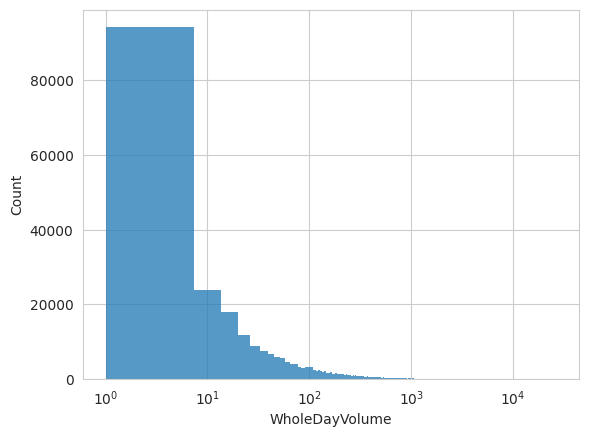

In [56]:
fig, ax = plt.subplots()

sns.histplot(options, x='WholeDayVolume')
ax.set_xscale('log')

## The underlying
The contracts in these datasets are for the Nikkei 225 index, and there are a variety of Nikkei 225 ETFs provided in the kaggle dataset.  I'll consider which one to use as the underlying, they should be in good approximation to the actual index

<Axes: xlabel='Date', ylabel='Close'>

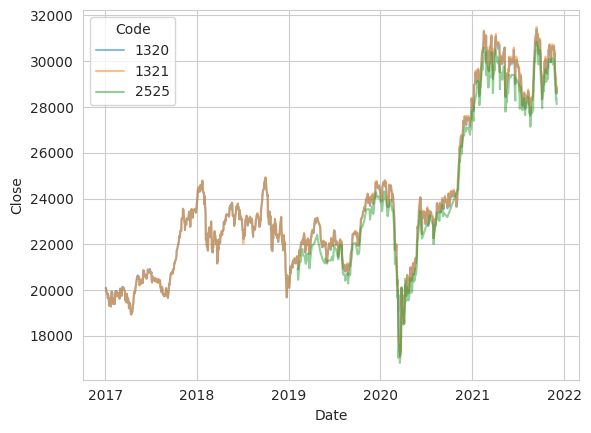

In [57]:
# a compilation of details about each security in the datasaet
# sec_stats = pd.read_csv(base_file_path+'stock_list.csv').rename({'SecuritiesCode':'Code'}, axis = 1).set_index('Code')

secondary_prices = pd.read_csv(base_file_path+'train_files/secondary_stock_prices.csv').rename({'SecuritiesCode':'Code'}, axis = 1)
secondary_prices.Date = pd.to_datetime(secondary_prices.Date)
secondary_prices = secondary_prices.set_index(['Code', 'Date']).sort_index()
nikkei_etfs = secondary_prices.loc[[1320, 1321, 2525]]

# remove the high memory 
del secondary_prices

fig, ax = plt.subplots()
sns.lineplot(nikkei_etfs, x = 'Date', y = 'Close', hue = 'Code', palette= 'tab10', alpha = 0.5)

In [58]:
# Merge the underlying stock data to the options dataframe
etf_code = 1320
nikkei_etfs['UnderlyingClose'] = nikkei_etfs.Close
options = options.reset_index().merge(nikkei_etfs.loc[etf_code, 'UnderlyingClose'], how = 'left', on = 'Date')
options = options.set_index(['Date', 'Expiry', 'Putcall', 'StrikePrice']).sort_index()


* The green security seems to be the odd one out.  By inspection we'll just use security code1 320, Daiwa ETF-Nikkei 225.

In [59]:
# cutoff for strike price
underlying_cutoff =15/100
# Some useful indices for groupby operations
indices = ['Date','Expiry', 'Putcall', ]

# Boolean indexer for contracts with strikes that are farther than 10% from the underlying.
complete_set =options.copy()
far_strikes_cond = complete_set.groupby(indices, group_keys=False).apply(
    lambda x: np.abs((x.index.get_level_values('StrikePrice')/x.UnderlyingClose-1))>underlying_cutoff)

# I want to keep the pricing data very far from the strikes for curiosity reasons.

options = complete_set[~far_strikes_cond].copy()

# Contracts list
a compendium of trading activity for all the contracts in the dataset

In [60]:
# Useful groupby indices

# A list of all the contracts in my dataset
contract_list = pd.DataFrame()

#aggregated trading volume (over all possible strikes) at a specific contract
contract_list['TotalVolume'] = options.groupby(indices)[['WholeDayVolume']].sum()

#Number of strike prices in a contract
contract_list['N_strikes']=options.reset_index('StrikePrice').groupby(indices)['StrikePrice'].nunique()


N_strikes = options.index.get_level_values('StrikePrice').unique().__len__()

# Filter contracts such that the whole day trading volume is greater than the number of strikes
contract_list = contract_list[contract_list.TotalVolume>1*N_strikes]

#rank the contracts by their volumes
contract_list['VolumeRank'] = contract_list['TotalVolume'].rank(ascending=False)
contract_list.sort_values(by = 'VolumeRank', inplace = True)


## Visualizing data

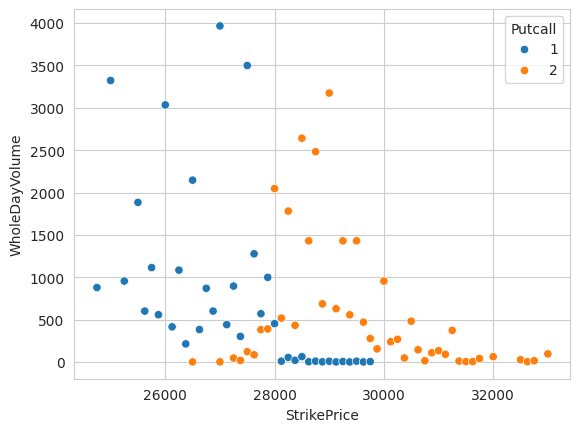

In [61]:
# Call and put close prices on a particular day for a particular expiry
fig, ax = plt.subplots()
# day = '2017-01-04'
day = '2021-12-03'
expiry = '2021-12-09'
df=options.loc[idx[day, expiry]]

j=sns.scatterplot(df, x='StrikePrice', y = 'WholeDayVolume', hue='Putcall', palette='tab10')

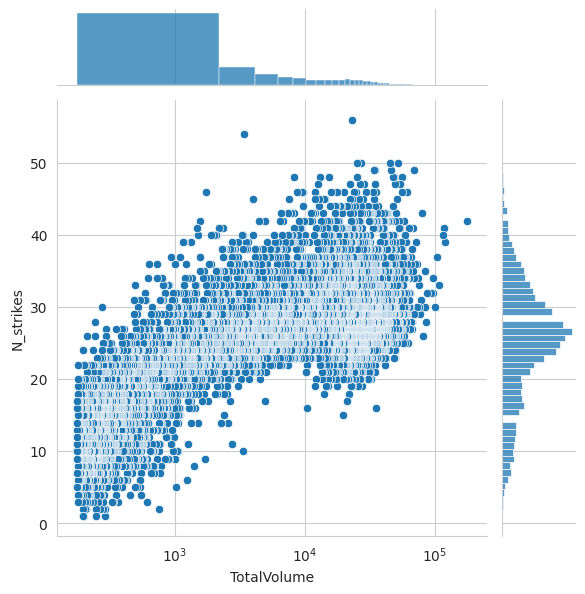

In [62]:
# fig, ax = plt.subplots(1, 2, figsize = (6.4*2, 4.8))

# sns.histplot(contract_list.N_strikes, ax=ax[0])
g=sns.jointplot(contract_list,y='N_strikes', x='TotalVolume')
g.ax_joint.set_xscale('log')

* A jointplot  of N_strikes v.s. TotalVolume suggests I should only consider securities that traded with at least 15 different strike prices. That would remove most of the low trading securities.

In [63]:
# Identify the contracts that have at least 20 strikes traded on a particular day
min_strikes = 20
good_training_examples=contract_list[contract_list.N_strikes>=min_strikes].sort_index().index

# Exclude the training examples that are not considered "good"
options = options[options.index.droplevel(-1).isin(good_training_examples)].copy()



In [64]:
np.inf

inf

In [65]:
def isotonicSmoother_pandas(
        df:pd.DataFrame, y_col:str, 
        direction_encoder_col=None, direction:bool=None, 
        index_level = -1,
        ymin = None, ymax = None):
    '''
    
    '''
    if direction_encoder_col==None:
        if direction ==None: dir = True
        else: dir = direction
    else:
        dir = df[direction_encoder_col].all()  # need to put a safety check here
    
    s = df[y_col].dropna()
    iso_regressor = IsotonicRegression(increasing = dir, y_min = ymin, y_max = ymax)
    y_hat = iso_regressor.fit_transform(X=s.index.get_level_values(index_level), y = s)
    return pd.Series(y_hat, s.index)

def weightedIsotonicSmoother_pandas(
        df:pd.DataFrame, 
        y_col:str, 
        weight_col:str,
        direction_encoder_col=None, direction:bool=None, 
        index_level = -1,
        ymin = None, ymax = None,
        ):
    '''
    
    '''
    if direction_encoder_col==None:
        if direction ==None: dir = True
        else: dir = direction
    else:
        dir = df[direction_encoder_col].all()  # need to put a safety check here
    
    data = df[[y_col, weight_col]].dropna()
    X, y, weights = data.index.get_level_values(index_level), data[y_col], data[weight_col]
    
    iso_regressor = IsotonicRegression(increasing = dir, y_min =ymin, y_max=ymax)
    iso_regressor.fit(X, y, sample_weight = weights)
    y_hat = iso_regressor.predict(X)
    return pd.Series(y_hat, index=data.index)

# Computing the implied probability distribution:
Brief outline:

1. Calculate implied CDF.
2. Try and perform a kolmogorov smirnov test on a well behaved example.
    * Seems like a decent well behaved example is (Timestamp('2021-09-06 00:00:00'), Timestamp('2021-09-09 00:00:00')).

Denoising procedure:
1. Denoise the call and put premium data with a volume weighted isotonic regressor. 
2. Calculate the bull spread, and then compute the implied CDF.
3. Denoise the implied CDF with another volume weighted isotonic regressor


In [66]:
options['logVolume'] = np.log1p(options['WholeDayVolume'])
weights_column = 'WholeDayVolume'
# weights_column = 'WholeDayVolume'
options['Putcall_encoder']=options.index.get_level_values('Putcall') ==1 # 1 for puts that have increasing premiums with increasing strikes

options['Close_iso'] = options.groupby(indices, group_keys=False).apply(
    isotonicSmoother_pandas, 'WholeDayClose', 'Putcall_encoder' )


options['Close_sm']=options.groupby(indices, group_keys=False).Close_iso.apply(savgol_pandas, 3, 1)

### Calculate the bull spreads (premium at strike K+1 - premium at strike K-1) ###
options['bull'] = bullSpread_pdgroupby(options['Close_iso'].groupby(indices, group_keys=False))
options['bull_sm'] =bullSpread_pdgroupby(options['Close_sm'].groupby(indices, group_keys=False))


options['K'] = options.index.get_level_values('StrikePrice')
options['dK']=bullSpread_pdgroupby(options['K'].groupby(indices, group_keys=False))

options['slope'] = options['bull']/(options['dK'])
options['slope_sm'] = options['bull_sm']/options['dK']

# calls are slope+1, puts are slope -1
options['cdf']= options['slope'] + (options['Putcall_encoder']==False)
# options['cdf_sm'] = options['slope_sm']+(options['Putcall_encoder']==False)

options['cdf_iso'] = options.groupby(indices, group_keys=False).apply(
        isotonicSmoother_pandas, y_col='cdf', direction=True, ymin=0, ymax=1)
# options['cdf_sm_iso'] = options.groupby(indices, group_keys=False).apply(
#     isotonicSmoother_pandas, y_col='cdf',  direction=True)

# weighted isotonic regressor; weight by the log1p of the volume 
options['Close_iso_weighted'] = options.groupby(indices, group_keys=False).apply(
    weightedIsotonicSmoother_pandas, 
    y_col='WholeDayClose', 
    weight_col = weights_column,
    direction_encoder_col ='Putcall_encoder',
    )
options['cdf_iso_weighted'] = options.groupby(indices, group_keys=False).apply(
        weightedIsotonicSmoother_pandas, y_col='cdf', 
        weight_col=weights_column, direction=True, ymin=0, ymax=1)
# options['cdf_clean'] = options['cdf_iso_weighted'].dropna().groupby(indices, group_keys=False).apply(
#     savgol_pandas, 5, 1
# )

options['butterfly'] = butterflySpread_pdgroupby(options['Close_sm'].groupby(indices, group_keys=False))
options['curvature'] = options.butterfly.div(options.dK.pow(2))

plot_args =  {'hue': 'Putcall', 'palette':'tab10'}

In [67]:
# OLD ATTEMPTS at trying to calculate butterfly spreads


# Less than 0.1s runtime 
# options['butterfly'] = butterflySpread_pdgroupby(options['Close_sm'].groupby(indices, group_keys=False))

#4.4 seconds runtime
#options.groupby(indices, group_keys=False)['WholeDayClose'].apply(pandas_butterfly_contract)

#4.4 seconds runtime
# options.groupby(indices, group_keys=False)['WholeDayClose'].apply(lambda x: x.shift(1)+x.shift(-1)-2*x)

# calculate the derivative
# options['K'] = options.index.get_level_values('StrikePrice')
# options['dK']=bullSpread_pdgroupby(options['K'].groupby(indices, group_keys=False))

# options['slope'] = options['bull']/(options['dK'])
# options['slope_sm'] = options['bull_sm']/options['dK']

# calls are slope+1, puts are slope +0


##  CDF cleaning plots

(Timestamp('2017-11-09 00:00:00'), Timestamp('2017-11-09 00:00:00'))
Interest rate is:  0.35999999999999993 Spread in the rate is: 4.370558682921689e-19


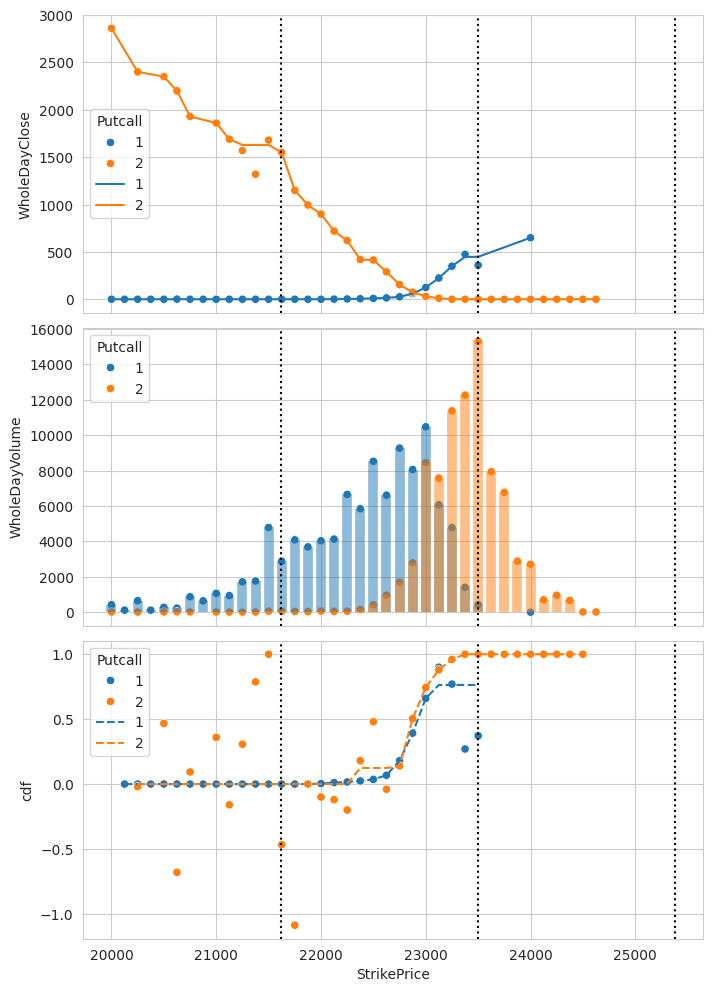

In [68]:
# 13 has a good example of going below the limits
# example 300 seems well behaved
example_number = 6
example = contract_list.index[example_number]
print(example[:-1])
df = options.loc[example[:-1]]
print('Interest rate is: ', 100*df.InterestRate.mean(), 'Spread in the rate is:', df.InterestRate.std())


fig, ax = plt.subplots(3, 1, figsize = (8, 2*6), sharex=True)
fig.subplots_adjust(hspace = 0.05)

# AXES 0
sns.scatterplot(df, x = 'StrikePrice', y = 'WholeDayClose', ax=ax[0], **plot_args)
# sns.lineplot(df, x = 'StrikePrice', y = 'Close_iso', alpha = 0.8,ax=ax[0], **plot_args)
sns.lineplot(df, x = 'StrikePrice', y = 'Close_iso_weighted', ax=ax[0], **plot_args)

# AXES 1
sns.scatterplot(df, x = 'StrikePrice', y='WholeDayVolume', ax = ax[1], alpha = 1, **plot_args)
for i, row in df.iterrows():
    if row['Putcall_encoder'] ==True:color = 'tab:blue'
    else: color = 'tab:orange'
    ax[1].vlines(row['K'], 0, row['WholeDayVolume'], alpha =0.5, linewidth = 7, color = color)
# ax[1].set_yscale('log')


# AXES 2
sns.scatterplot(df, x = 'StrikePrice', y = 'cdf', ax=ax[2], **plot_args)
# sns.lineplot(df, x = 'StrikePrice', y = 'cdf_iso', ax=ax[2], linestyle = '-', **plot_args)
sns.lineplot(df, x = 'StrikePrice', y = 'cdf_iso_weighted', ax=ax[2], linestyle='--', **plot_args)
# sns.lineplot(df, x = 'StrikePrice', y = 'cdf_clean', ax=ax[2], linestyle='-', **plot_args)

# Annotations 
for a in ax:
    for percentile in [0.92, 1, 1.08]:
        a.axvline(df['UnderlyingClose'].iloc[0]*percentile, color = 'k', linestyle = ':')

In [191]:
def weightedSum_pandas(df:pd.DataFrame, y_col:str, weight_col:str, stack_level:str, index_level=-1, dropna=True):
    '''
    Returns a pandas series that is a weighed average of two similiar series, 
    that have a duplicated bottom tier index.  
    An example of such would be the prices of options on a given day for a given expiry.  
    Such an example would have pricings data for call options, and pricing data for put options,
    at potentially overlapping strikes.  

    Args:
    '''
    if dropna==True: data = df[[y_col, weight_col]].dropna()
    weighted_y = (data[weight_col]*data[y_col]).unstack(stack_level).sort_index().sum(axis=1)
    weights = data[weight_col].unstack(stack_level).sort_index().sum(axis = 1)
    return pd.Series(data = weighted_y/weights, index = weighted_y.index)
    # df = data[[y_col, weight_col]].unstack(stack_level)

from scipy.interpolate import PchipInterpolator

def splineInterp_pandas(series:pd.Series,  N=None, index_level=-1,):
    '''
    Returns an interpolated pandas series,
    with either the same index or a coarser/finer grained index (depending on N.)

    Args:

    '''
    s = series.dropna()
    x, y = s.index.get_level_values(index_level), s.values
    if N == None: x_samp = x
    else: x_samp = np.linspace(x.min(), x.max(), N)
    print(x_samp)
    interp = PchipInterpolator(x,y)
    
    out = pd.Series(data = interp(x_samp), index = x_samp, name = 'out')
    merged_series = pd.merge(s, out, how ='outer', left_index=True, right_on = 'index')
    # series_resample = interp(x_samp)
    
    return merged_series

def deriviative_fromSpline_pandas(series, index_level = -1, N =None):
    '''
    Returns the derivative of a pandas series from a monotonic interpolator. 
    Depending on N, can be coarser or finer grained than the original index.

    Args:

    '''
    s = series.dropna()
    x, y = s.index.get_level_values(index_level), s.values 
    if N == None: x_samp = x
    else: x_samp = np.linspace(x.min(), x.max(), N)
    interp = PchipInterpolator(x, y)
    dydx = interp.derivative()(x)

    return pd.Series(index = s.index, data = dydx)


In [192]:
implied.cdf.groupby(indices[:-1], group_keys=True).apply(splineInterp_pandas, N=10)

[17250.         17708.33333333 18166.66666667 18625.
 19083.33333333 19541.66666667 20000.         20458.33333333
 20916.66666667 21375.        ]


MergeError: Not allowed to merge between different levels. (2 levels on the left, 1 on the right)

# Blending implied CDFs

* If I take a volume weighted average of the CDFs from put option pricing and call option pricing, I should be able to get a relatively smooth montonic curve.  
* I'd imagine

In [70]:
implied = pd.DataFrame()
implied['cdf'] = options.groupby(indices[:-1], group_keys=False).apply(
    weightedSum_pandas, 
    y_col='cdf_iso_weighted', weight_col='WholeDayVolume', 
    stack_level='Putcall'
)
# implied = implied.sort_index()
implied['pmf']=implied.groupby(indices[:-1], group_keys=False).cdf.diff()
implied['K'] = implied.index.get_level_values('StrikePrice')


MultiIndex([('2017-01-04', '2017-01-12', 17250.0),
            ('2017-01-04', '2017-01-12', 21375.0)],
           names=['Date', 'Expiry', 'StrikePrice'])


ValueError: Length of values (2000) does not match length of index (2)

In [71]:
implied = pd.DataFrame()
implied['cdf'] = options.groupby(indices[:-1], group_keys=False).apply(
    weightedSum_pandas, 
    y_col='cdf_iso_weighted', weight_col='WholeDayVolume', 
    stack_level='Putcall'
)
# implied = implied.sort_index()
implied['pmf']=implied.groupby(indices[:-1], group_keys=False).cdf.diff()
implied['K'] = implied.index.get_level_values('StrikePrice')

In [72]:
# implied.groupby(indices[:-1], group_keys=False).cdf.apply(
#     splineInterp_pandas, N = 100
#     )

# Blended CDF plots

(Timestamp('2018-01-09 00:00:00'), Timestamp('2018-01-11 00:00:00'))


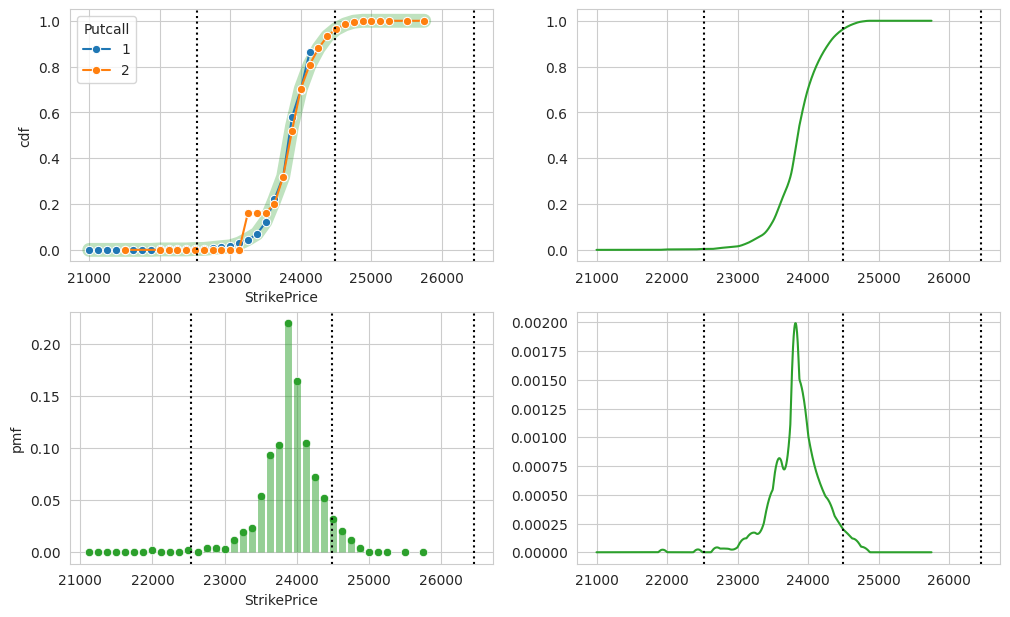

In [222]:

i = 93
example = contract_list.index[i]
print(example[:-1])
df = options.loc[example[:-1]]
imp_df = implied.loc[example[:-1]]

x_data = imp_df.index.get_level_values(-1)
y_data = imp_df.cdf.values
interp = PchipInterpolator(x= x_data, y = y_data)
x_samp = np.linspace(x_data.min(), x_data.max(), num = 1000)
y_samp = interp(x_samp)
dydx = np.gradient(y_samp)/np.gradient(x_samp)

fig, ax = plt.subplots(2,2,figsize = (8*1.5,6*1.2) )


# AXES[0,0] CDF blending
sns.lineplot(imp_df, x='StrikePrice', y='cdf', ax=ax[0, 0], color = 'tab:green', linewidth = 10,alpha =0.3)
sns.lineplot(df, x = 'StrikePrice', y = 'cdf_iso_weighted', marker = 'o', ax=ax[0, 0], **plot_args)

# AXES[1, 0]
sns.scatterplot(imp_df, x = 'StrikePrice', y='pmf', ax = ax[1, 0], alpha = 1, color='tab:green')
for i, row in imp_df.iterrows():
    ax[1, 0].vlines(row['K'], 0, row['pmf'], alpha =0.5, linewidth = 5, color = 'tab:green')

# AXES[0,1]
ax[0, 1].plot(x_samp, y_samp, color='tab:green')

# AXES[1, 1]
ax[1,1].plot(x_samp, dydx, color='tab:green')


# Annotations 
for axe in ax:
    for a in axe:
        for percentile in [0.92, 1, 1.08]:
            # print(df['UnderlyingClose'].iloc[0]*percentile)
            a.axvline(df['UnderlyingClose'].iloc[0]*percentile, color = 'k', linestyle = ':')

# Comments on the PMF and PDF
* Just by scrolling through some examples, it seems like I've computed all sorts of funky distributions.  
* To resummarize this approach, I blended the CDFs weighted by the volume of trades at a particular strike

In [74]:
# options.groupby(['Date', 'Expiry'], group_keys=False).apply()

## CDF calculation Notes
General comments on the data cleaning:
* Isotonic regression with the premiums vs strikes seems to be a good diea.  
* Isotonoic regressor should be given that ymin and y max are 0 and 1 for the cdf, it seems like that what the regressor converges to usually.
* Maybe I should use weighted isotonic regression, and weight by the log of the volume.  
* interesting paper link https://dl.acm.org/doi/10.1145/1102351.1102430 suggest platt scaling might be something to look into

Finance/scientific remarks:
* It's interesting that the tail behaviors of the put and call options have different tails.  In some sense, the implied probability distribution from puts and calls reveals the sentiment of bullish investors v.s. the bearish investors.
* But these tails derive from quite noisy data.  Perhaps blending the two distributions would reveal some facts about overall volatility in the market.  

# Goodness of fit testing

## Arguments for GOF regression 
- It makes sense to use reduced chi-square, my variance should probably be related 

## Arguments for GOF distribution testing Kolmogorov-smirnov teseting
- Scipy's `kstest` works well if I have observations of a random variable from some family of distributions, but my problem is a little different.
- I already have a measure of the CDF, so I should be able to compute the KS test statistic.  
- It's a little questionable whether the test statistic converges asymptotically to the Colmogorov distribution.
    * The original formulation of the KS test statistic is with the empirical cumulative distribution function.
    * My CDF's are NOT empirical cumulative distribution functions, they're something else.
    * Nevertheless, let's proceed and pretend that we observed such a distribution.  I'm using goodness of fit so it's tough to think about something besides Kolmogorov-Smirnov.  Maybe reduce chi-squared would work if I take my error bars to be some heteroscedatic error.

# Below is work to be continued

In [75]:
# # Assuming 'options' is your DataFrame
# x = df.index.get_level_values('StrikePrice')
# y =df['bull']


# # Sort the data by x values
# sorted_indices = np.argsort(x)
# x_sorted = x[sorted_indices]
# y_sorted = y.iloc[sorted_indices]

# # Fit isotonic regression model
# iso_reg = IsotonicRegression()
# y_iso = iso_reg.fit_transform(x_sorted, y_sorted)

# # Plot original data and isotonic regression line
# fig, ax = plt.subplots(figsize=(8, 6))
# sns.scatterplot(x=x_sorted, y=y_sorted, ax=ax, label='Original Data')
# plt.plot(x_sorted, y_iso, color='red', label='Isotonic Regression')
# plt.xlabel('Strike Price')
# plt.ylabel('Bull Data')
# plt.title('Isotonic Regression on Bull Data vs. Strike Price')
# plt.legend()
# plt.show()





# from scipy.interpolate import PchipInterpolator

# # Sort the data by x values
# sorted_indices = np.argsort(x)
# x_sorted = x[sorted_indices]
# y_sorted = y.iloc[sorted_indices]

# # Perform monotonic cubic interpolation
# interp_func = PchipInterpolator(x_sorted, y_sorted)

# # Generate interpolated values
# x_interp = np.linspace(min(x_sorted), max(x_sorted), 1000)
# y_interp = interp_func(x_interp)

# # Plot original data and interpolated curve
# fig, ax = plt.subplots(figsize=(8, 6))
# sns.scatterplot(x=x, y=y, ax=ax, label='Original Data')
# plt.plot(x_interp, y_interp, color='red', label='Monotonic Cubic Interpolation')
# plt.xlabel('Strike Price')
# plt.ylabel('Bull Data')
# plt.title('Monotonic Cubic Interpolation on Bull Data vs. Strike Price')
# plt.legend()
# plt.show()


In [76]:
# from scipy.interpolate import monotone_spline

# # Sort the data by x values
# sorted_indices = np.argsort(x)
# x_sorted = x[sorted_indices]
# y_sorted = y.iloc[sorted_indices]

# # Perform monotonic smoothing
# smoothed_y = monotone_spline(x_sorted, y_sorted)

# # Plot original data and smoothed curve
# fig, ax = plt.subplots(figsize=(8, 6))
# sns.scatterplot(x=x, y=y, ax=ax, label='Original Data')
# plt.plot(x_sorted, smoothed_y, color='red', label='Monotonic Smoothing')
# plt.xlabel('Strike Price')
# plt.ylabel('Bull Data')
# plt.title('Monotonic Smoothing on Bull Data vs. Strike Price')
# plt.legend()
# plt.show()


In [77]:
# TO DO: Resample points from from strikes maybe?  

In [78]:
options['pdf'] = options.groupby(indices, group_keys=False)['curvature'].apply(
    GaussKernelSmoother_pandas,4)

## Implied PDF

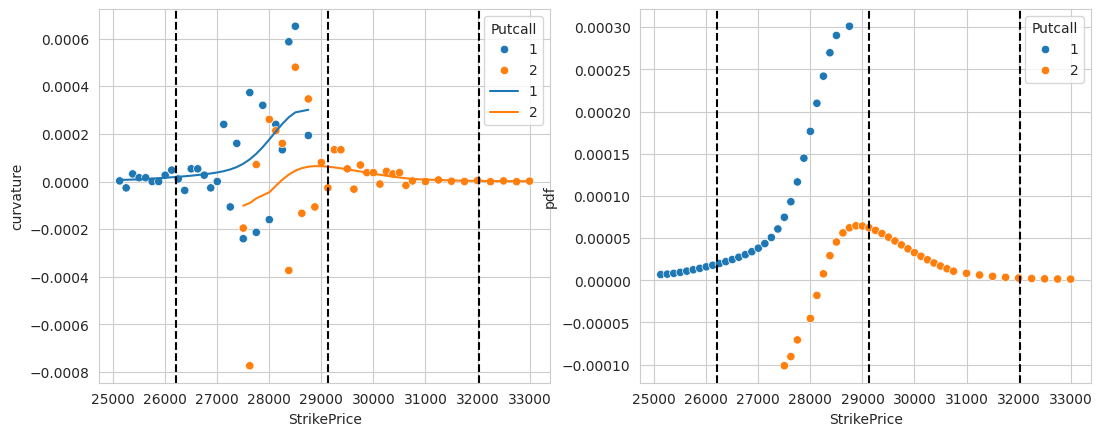

In [79]:
fig,ax = plt.subplots(1,2, figsize = (6.4*2, 4.85))
df = options.loc[example[:-1]]

# sns.scatterplot(df, x = 'StrikePrice', y = 'pdf', )
sns.scatterplot(df, x = 'StrikePrice', y = 'curvature',ax=ax[0], hue='Putcall', palette= 'tab10')
# sns.lineplot(df, x = 'StrikePrice', y = 'pdf', ax=ax[1], hue ='Putcall', palette= 'tab10')

sns.lineplot(df, x = 'StrikePrice', y = 'pdf', color = 'tab:green', ax=ax[0], hue='Putcall', palette= 'tab10')

# sns.lineplot(df, x = 'StrikePrice', y = 'pdf', ax=ax[1], hue ='Putcall', palette= 'tab10')

sns.scatterplot(df, x='StrikePrice', y='pdf', ax=ax[1], color='tab:green', hue='Putcall', palette= 'tab10')

for a in ax: 
    a.axvline(df['UnderlyingClose'].iloc[0], color = 'k', linestyle = '--')
    a.axvline(df['UnderlyingClose'].iloc[0]*0.9, color = 'k', linestyle = '--')
    a.axvline(df['UnderlyingClose'].iloc[0]*1.1, color = 'k', linestyle = '--')

# Some thoughts:
Obvoiusly high probability of the price falling well below the underlying close is just erroneus (in the orange plot). Same goes for the price rising to 24k when the udnerlying is at 22k is also probably erroneus.

The wise thing to do might be to remove contracts that are trading far from the underlying.  Since it's an index, removing strikes that are more $\pm$ 10% from the underlying close seems reasonable.

# Kolmogorov-Smirnov goodness of fit testing
Try and use goodness fit testing to find the family of distributions. 

In [80]:
options['close_smooth']=options.groupby(indices, group_keys=False).WholeDayClose.apply(savgol_pandas, 10, 1)
options['dirty_cdf'] = bullSpread_pdgroupby(options['WholeDayClose'].groupby(indices, group_keys=False))
options['implied_cdf'] = bullSpread_pdgroupby(options['close_smooth'].groupby(indices, group_keys=False)).div(options.dK)

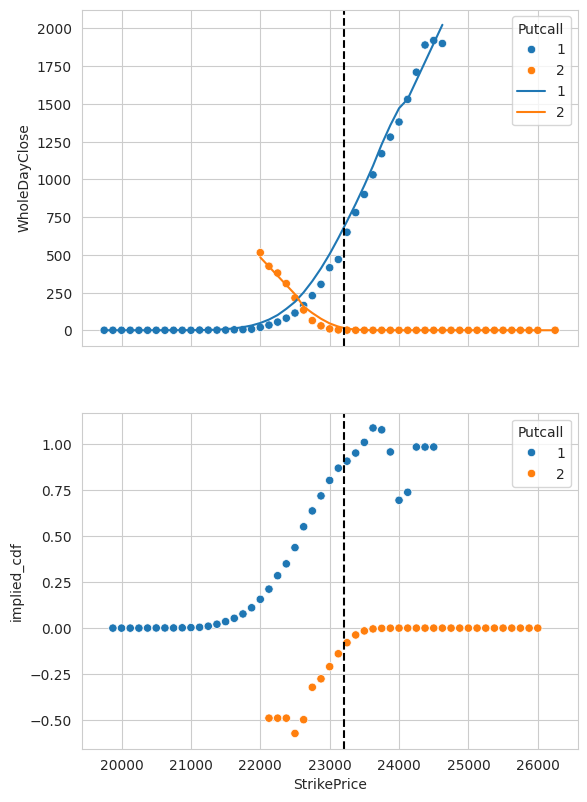

In [81]:
example_1 = contract_list.index[3]

df=options.loc[example_1[:-1]]



fig, ax = plt.subplots(2, 1, figsize = (6.4, 2*4.8), sharex=True)

sns.scatterplot(df, x = 'StrikePrice', y = 'WholeDayClose', ax=ax[0], hue ='Putcall', palette='tab10')
sns.lineplot(df, x = 'StrikePrice', y = 'close_smooth', ax=ax[0], hue ='Putcall', palette='tab10')

# sns.scatterplot(df, x = 'StrikePrice', y = 'dirty_cdf', ax=ax[1], hue ='Putcall', palette='tab10')
sns.scatterplot(df, x = 'StrikePrice', y = 'implied_cdf', ax=ax[1], hue ='Putcall', palette='tab10')

for a in ax: a.axvline(df['UnderlyingClose'].iloc[0], color = 'k', linestyle = '--')


# Some thougts and ideas to pick back up on
* Might be wise to remove extreme strikes, that are far from the underlying.
